# Desarrollo de un pipeline

In [ ]:
from data.image_converter import get_images

images_yes, images_no = get_images(image_size=(224, 224))

im_yes = images_yes[0]
im_no = images_no[0]

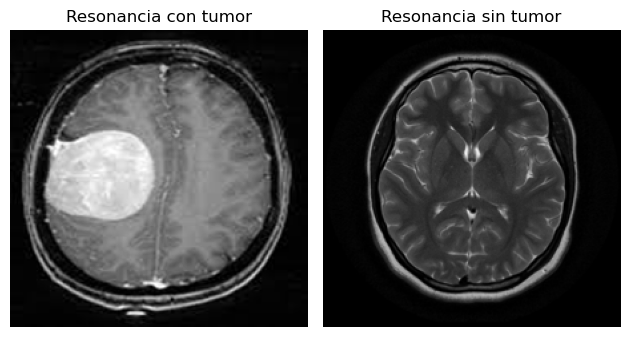

In [391]:
import matplotlib.pyplot as plt

plt.figure()

plt.subplot(1, 2, 1)
plt.title('Resonancia con tumor')
plt.imshow(im_yes, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Resonancia sin tumor')
plt.imshow(im_no, cmap='gray')
plt.axis('off')

plt.tight_layout()

## Filtro radial

In [469]:
from gtda.images import RadialFiltration
from itertools import product
import numpy as np

centers = product((37, 112, 187), (37, 112, 187))
centers = list(centers)
centers.sort(key=lambda x: x[1])
radial_filtrations = [RadialFiltration(center=np.asarray(center), n_jobs=-1) for center in centers]

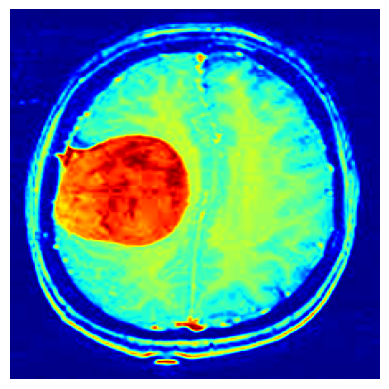

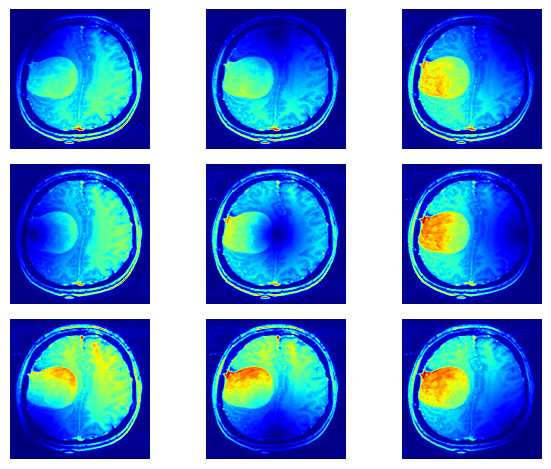

In [471]:
im_yes = images_yes[0][None, :, :]

plt.imshow(im_yes[0], cmap='jet')
plt.axis('off')
plt.figure()
for i, filtration in enumerate(radial_filtrations):
    im_yes_radial = filtration.fit_transform(im_yes)
    im_yes_radial_plot = filtration.plot(im_yes_radial, colorscale='jet')
    
    plt.subplot(3, 3, i+1)
    plt.imshow(im_yes_radial_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
plt.tight_layout()

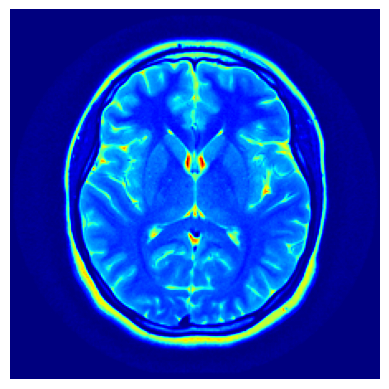

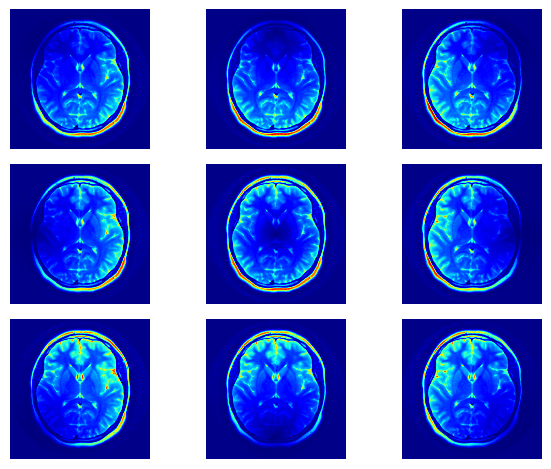

In [473]:
from gtda.images import RadialFiltration
from itertools import product

im_no = images_no[0][None, :, :]

plt.imshow(im_no[0], cmap='jet')
plt.axis('off')
plt.figure()
for i, filtration in enumerate(radial_filtrations):
    im_no_radial = filtration.fit_transform(im_no)
    im_no_radial_plot = filtration.plot(im_no_radial, colorscale='jet')
    
    plt.subplot(3, 3, i+1)
    plt.imshow(im_no_radial_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
plt.tight_layout()

In [439]:
from gtda.homology import CubicalPersistence
from gtda.diagrams import Scaler

cubical_persistence = CubicalPersistence(n_jobs=-1)
im_yes_cubical = cubical_persistence.fit_transform(im_yes)
im_no_cubical = cubical_persistence.fit_transform(im_no)

scaler = Scaler(n_jobs=-1)
im_yes_scaled = scaler.fit_transform(im_yes_cubical)
im_no_scaled = scaler.fit_transform(im_no_cubical)

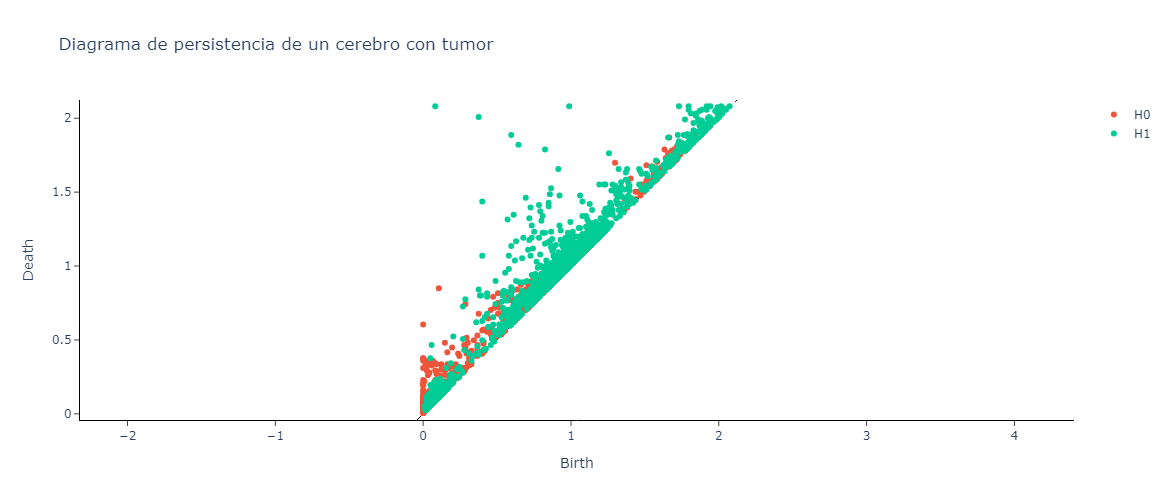

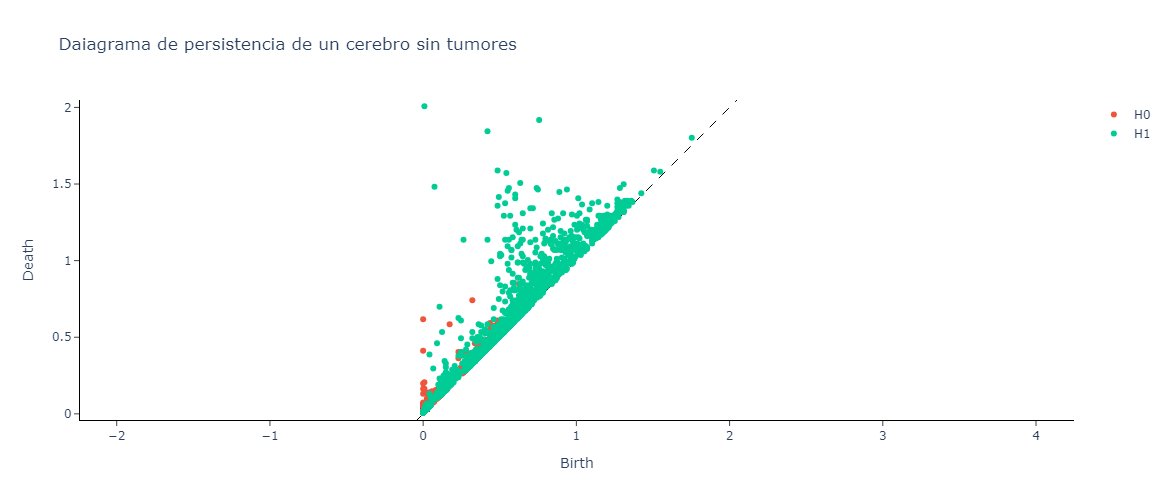

In [433]:
im_yes_scaled_plot = scaler.plot(im_yes_scaled, 
                                         plotly_params={'layout':{'title':'Diagrama de persistencia de un cerebro con tumor'}})
im_no_scaled_plot = scaler.plot(im_no_scaled, 
                                       plotly_params={'layout':{'title':'Daiagrama de persistencia de un cerebro sin tumores'}})

im_yes_scaled_plot.show()
im_no_scaled_plot.show()

In [435]:
from gtda.diagrams import HeatKernel

heat_kernel = HeatKernel(sigma=0.15, n_bins=60, n_jobs=-1)

im_yes_heat = heat_kernel.fit_transform(im_yes_scaled)
im_no_heat = heat_kernel.fit_transform(im_no_scaled)

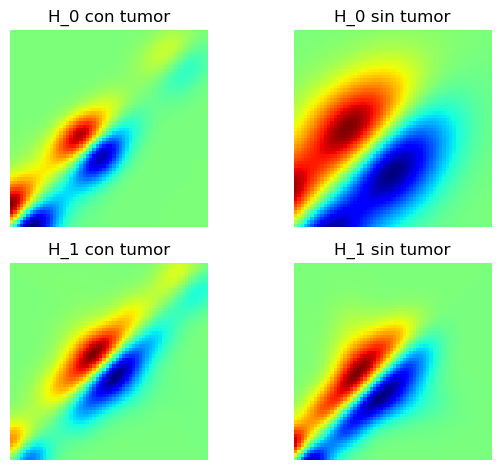

In [436]:
im_yes_heat_plot_0 = heat_kernel.plot(im_yes_heat, homology_dimension_idx=0)
im_yes_heat_plot_1 = heat_kernel.plot(im_yes_heat, homology_dimension_idx=1)
im_no_heat_plot_0 = heat_kernel.plot(im_no_heat, homology_dimension_idx=0)
im_no_heat_plot_1 = heat_kernel.plot(im_no_heat, homology_dimension_idx=1)

plt.figure()

plt.subplot(2, 2, 1)
plt.title('H_0 con tumor')
plt.imshow(im_yes_heat_plot_0['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('H_0 sin tumor')
plt.imshow(im_no_heat_plot_0['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('H_1 con tumor')
plt.imshow(im_yes_heat_plot_1['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title('H_1 sin tumor')
plt.imshow(im_no_heat_plot_1['data'][0]['z'], cmap='jet')
plt.axis('off')

plt.tight_layout()

## Distintos filtros de densidad con un radio pequeño

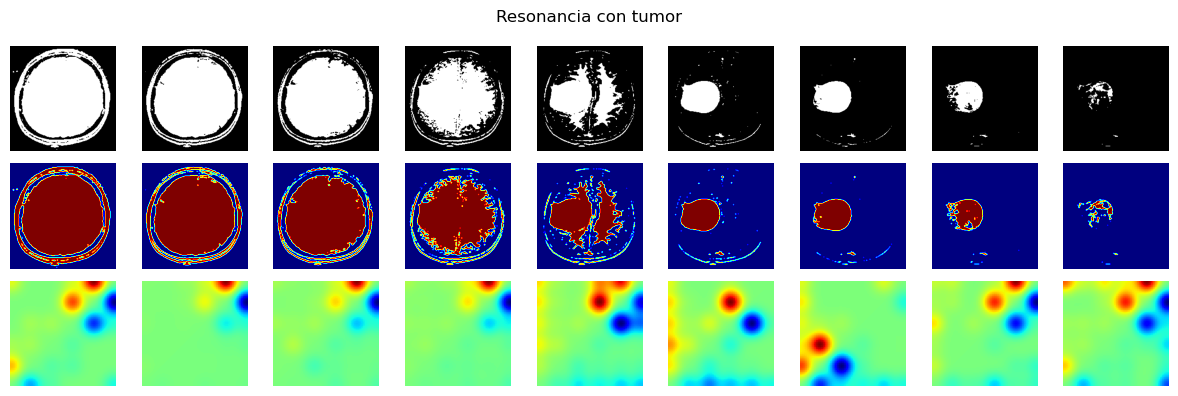

In [290]:
from gtda.images import Binarizer
from gtda.images import DensityFiltration
density_filtration = DensityFiltration(radius=1, metric='euclidean', n_jobs=-1)

plt.figure(figsize=(12, 4))
plt.suptitle('Resonancia con tumor')
for threshold in range(1, 10):
    binarizer = Binarizer(threshold=threshold/10, n_jobs=-1)
    im_yes_binarized = binarizer.fit_transform(im_yes)
    im_yes_binarized_plot = binarizer.plot(im_yes_binarized)
    plt.subplot(3, 9, threshold)
    plt.imshow(im_yes_binarized_plot['data'][0]['z'], cmap='gray')
    plt.axis('off')

    #im_yes_binarized_radial = radial_filtration.fit_transform(im_yes_binarized)
    #im_yes_binarized_radial_plot = radial_filtration.plot(im_yes_binarized_radial)
    im_yes_density = density_filtration.fit_transform(im_yes_binarized)
    im_yes_density_plot = density_filtration.plot(im_yes_density)
    plt.subplot(3, 9, threshold+9)
    plt.imshow(im_yes_density_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
    im_yes_cubical = cubical_pesistence.fit_transform(im_yes_density)
    im_yes_cubical_scaled = scaler.fit_transform(im_yes_cubical)
    im_yes_cubical_heat = heat_kernel.fit_transform(im_yes_cubical_scaled)
    im_yes_cubical_heat_plot = heat_kernel.plot(im_yes_cubical_heat, homology_dimension_idx=1)
    plt.subplot(3, 9, threshold+18)
    plt.imshow(im_yes_cubical_heat_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
plt.tight_layout()

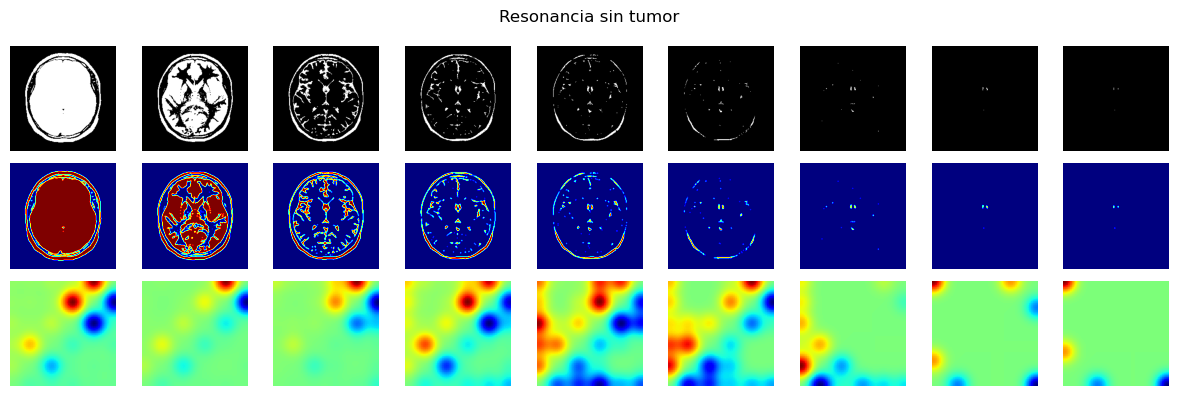

In [292]:
plt.figure(figsize=(12, 4))
plt.suptitle('Resonancia sin tumor')
for threshold in range(1, 10):
    binarizer = Binarizer(threshold=threshold/10, n_jobs=-1)
    im_no_binarized = binarizer.fit_transform(im_no)
    im_no_binarized_plot = binarizer.plot(im_no_binarized)
    plt.subplot(3, 9, threshold)
    plt.imshow(im_no_binarized_plot['data'][0]['z'], cmap='gray')
    plt.axis('off')

    #im_no_binarized_radial = radial_filtration.fit_transform(im_no_binarized)
    #im_no_binarized_radial_plot = radial_filtration.plot(im_no_binarized_radial)
    im_no_density = density_filtration.fit_transform(im_no_binarized)
    im_no_density_plot = density_filtration.plot(im_no_density)
    plt.subplot(3, 9, threshold+9)
    plt.imshow(im_no_density_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
    im_no_cubical = cubical_pesistence.fit_transform(im_no_density)
    im_no_cubical_scaled = scaler.fit_transform(im_no_cubical)
    im_no_cubical_heat = heat_kernel.fit_transform(im_no_cubical_scaled)
    im_no_cubical_heat_plot = heat_kernel.plot(im_no_cubical_heat, homology_dimension_idx=1)
    plt.subplot(3, 9, threshold+18)
    plt.imshow(im_no_cubical_heat_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
plt.tight_layout()

## Distintos filtros de densidad con un radio grande

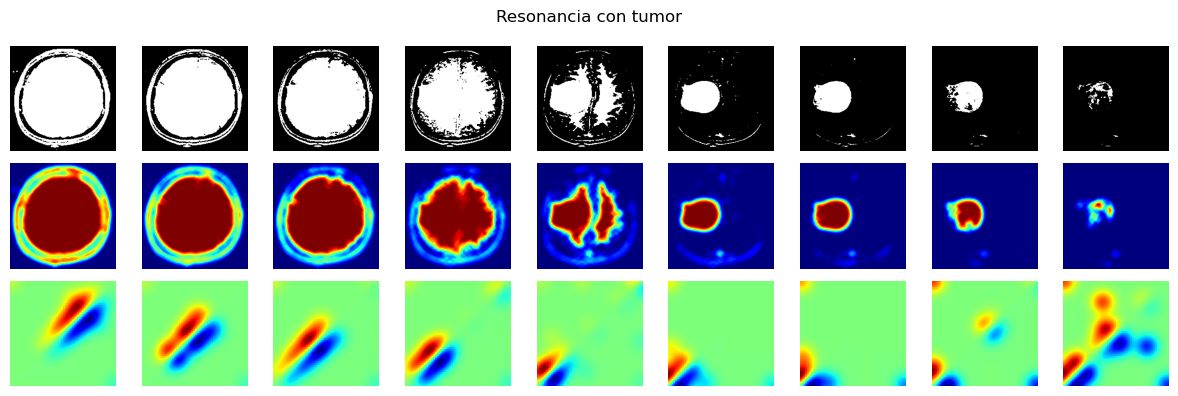

In [324]:
density_filtration = DensityFiltration(radius=10, metric='cityblock', n_jobs=-1)

plt.figure(figsize=(12, 4))
plt.suptitle('Resonancia con tumor')
for threshold in range(1, 10):
    binarizer = Binarizer(threshold=threshold/10, n_jobs=-1)
    im_yes_binarized = binarizer.fit_transform(im_yes)
    im_yes_binarized_plot = binarizer.plot(im_yes_binarized)
    plt.subplot(3, 9, threshold)
    plt.imshow(im_yes_binarized_plot['data'][0]['z'], cmap='gray')
    plt.axis('off')

    im_yes_density = density_filtration.fit_transform(im_yes_binarized)
    im_yes_density_plot = density_filtration.plot(im_yes_density)
    plt.subplot(3, 9, threshold+9)
    plt.imshow(im_yes_density_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
    im_yes_cubical = cubical_pesistence.fit_transform(im_yes_density)
    im_yes_cubical_scaled = scaler.fit_transform(im_yes_cubical)
    im_yes_cubical_heat = heat_kernel.fit_transform(im_yes_cubical_scaled)
    im_yes_cubical_heat_plot = heat_kernel.plot(im_yes_cubical_heat, homology_dimension_idx=1)
    plt.subplot(3, 9, threshold+18)
    plt.imshow(im_yes_cubical_heat_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
plt.tight_layout()

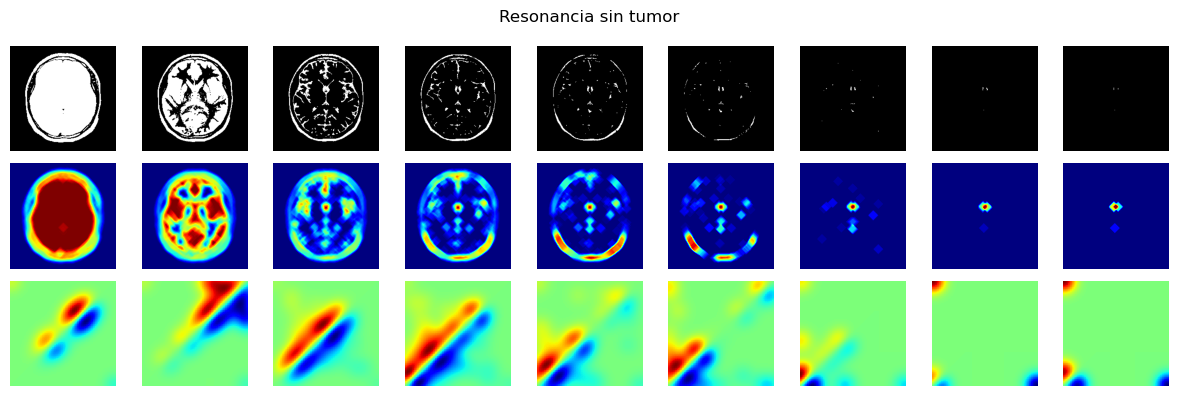

In [325]:
plt.figure(figsize=(12, 4))
plt.suptitle('Resonancia sin tumor')
for threshold in range(1, 10):
    binarizer = Binarizer(threshold=threshold/10, n_jobs=-1)
    im_no_binarized = binarizer.fit_transform(im_no)
    im_no_binarized_plot = binarizer.plot(im_no_binarized)
    plt.subplot(3, 9, threshold)
    plt.imshow(im_no_binarized_plot['data'][0]['z'], cmap='gray')
    plt.axis('off')

    im_no_density = density_filtration.fit_transform(im_no_binarized)
    im_no_density_plot = density_filtration.plot(im_no_density)
    plt.subplot(3, 9, threshold+9)
    plt.imshow(im_no_density_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
    im_no_cubical = cubical_pesistence.fit_transform(im_no_density)
    im_no_cubical_scaled = scaler.fit_transform(im_no_cubical)
    im_no_cubical_heat = heat_kernel.fit_transform(im_no_cubical_scaled)
    im_no_cubical_heat_plot = heat_kernel.plot(im_no_cubical_heat, homology_dimension_idx=1)
    plt.subplot(3, 9, threshold+18)
    plt.imshow(im_no_cubical_heat_plot['data'][0]['z'], cmap='jet')
    plt.axis('off')
    
plt.tight_layout()

## Diseño de un Pipeline

In [475]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn import set_config
from gtda.diagrams import PersistenceEntropy, Amplitude

thresholds = np.arange(0.1, 1, 0.1)
centers = product({37, 112 ,187}, {37, 112 ,187})

binarizers = ([Binarizer(threshold=threshold, n_jobs=-1) for threshold in thresholds])
radial_filtrations = ([RadialFiltration(center=np.asarray(center), n_jobs=-1) for center in centers])
density_filtrations = ([DensityFiltration(radius=1, metric='euclidean', n_jobs=-1), 
                        DensityFiltration(radius=10, metric='cityblock', n_jobs=-1)])

steps_original = [
    [
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1)
    ] for filtration in radial_filtrations 
]

steps_binarizer = [
    [
        binarizer,
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1)
    ] for filtration in density_filtrations
    for binarizer in binarizers
]

metric_iter = [
    {'metric':'bottleneck', 'metric_params':{}},
    {'metric':'wasserstein', 'metric_params':{'p':1}},
    {'metric':'wasserstein', 'metric_params':{'p':2}},
    {'metric':'landscape', 'metric_params':{'p':1, 'n_layers':1, 'n_bins':100}},
    {'metric':'landscape', 'metric_params':{'p':1, 'n_layers':2, 'n_bins':100}},
    {'metric':'landscape', 'metric_params':{'p':2, 'n_layers':1, 'n_bins':100}},
    {'metric':'landscape', 'metric_params':{'p':2, 'n_layers':2, 'n_bins':100}},
    {'metric':'betti', 'metric_params':{'p':1, 'n_bins':100}},
    {'metric':'betti', 'metric_params':{'p':2, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':1, 'sigma':1.6, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':1, 'sigma':3.2, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':2, 'sigma':1.6, 'n_bins':100}},
    {'metric':'heat', 'metric_params':{'p':2, 'sigma':3.2, 'n_bins':100}}
]
amplitudes = ([Amplitude(**metric, n_jobs=-1) for metric in metric_iter])
amplitudes_union = make_union(*[PersistenceEntropy(nan_fill_value=-1)] + amplitudes)

pipe_original = make_union(
    *[make_pipeline(*step, amplitudes_union) for step in steps_original], n_jobs=-1
)

pipe_binarizer = make_union(
    *[make_pipeline(*step, amplitudes_union) for step in steps_binarizer], n_jobs=-1
)

tda_pipeline = make_union(pipe_original, pipe_binarizer)

set_config(display='diagram')
tda_pipeline

FeatureUnion(transformer_list=[('featureunion-1',
                                FeatureUnion(n_jobs=-1,
                                             transformer_list=[('pipeline-1',
                                                                Pipeline(steps=[('radialfiltration',
                                                                                 RadialFiltration(center=array([112, 112]),
                                                                                                  n_jobs=-1)),
                                                                                ('cubicalpersistence',
                                                                                 CubicalPersistence(n_jobs=-1)),
                                                                                ('scaler',
                                                                                 Scaler(n_jobs=-1)),
                                                                                ('featureunion',
                                                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                                                 Persis...
                                                                                                                           metric_params={'n_bins': 100,
                                                                                                                                          'p': 1,
                                                                                                                                          'sigma': 1.6},
                                                                                                                           n_jobs=-1)),
                                                                                                                ('amplitude-11',
                                                                                                                 Amplitude(metric='heat',
                                                                                                                           metric_params={'n_bins': 100,
                                                                                                                                          'p': 1,
                                                                                                                                          'sigma': 3.2},
                                                                                                                           n_jobs=-1)),
                                                                                                                ('amplitude-12',
                                                                                                                 Amplitude(metric='heat',
                                                                                                                           metric_params={'n_bins': 100,
                                                                                                                                          'p': 2,
                                                                                                                                          'sigma': 1.6},
                                                                                                                           n_jobs=-1)),
                                                                                                                ('amplitude-13',
                                                                                                                 Amplitude(metric='heat',
                                                                                                                           metric_params={'n_bins': 100,

In [477]:
%%time
im_yes_pipeline = tda_pipeline.fit_transform(im_yes)
im_yes_pipeline.shape

CPU times: total: 141 ms
Wall time: 14.9 s


(1, 756)